<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/tripletVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

In [6]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

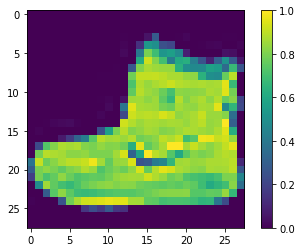

label:  9


In [10]:
show_image(train_images[0])
print("label: ",train_labels[0])

In [16]:
image_shoe_index = np.where(train_labels==9)
train_image_shoe = train_images[image_shoe_index]

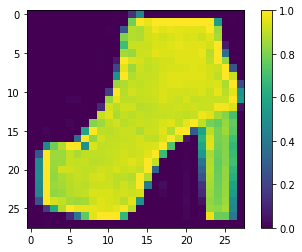

In [20]:
show_image(train_image_shoe[4])

In [22]:
image_tshirt_index = np.where(train_labels==0)
train_image_tshirt = train_images[image_tshirt_index]

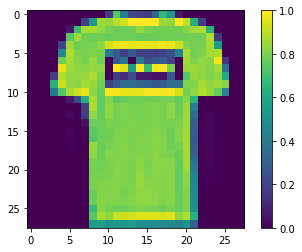

In [23]:
show_image(train_image_tshirt[0])

In [27]:
image_trouser_index = np.where(train_labels==1)
train_image_trouser = train_images[image_trouser_index]

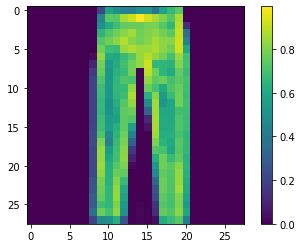

In [28]:
show_image(train_image_trouser[0])

In [29]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)